<a href="https://colab.research.google.com/github/Willgnner-Santos/LLM_PortugueseLegalDocClassifier/blob/main/Sabia-3/Descri%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sabiá-3 via API**

In [ ]:
# Montagem do Google Drive para acessar arquivos
from google.colab import drive
drive.mount('/content/drive')

# Instalação de pacotes necessários
!pip install tiktoken langchain-community langchainhub langchain_openai langchain
!!pip install imbalanced-learn

import pandas as pd
import requests
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import tiktoken

# Função para contagem de tokens
enc = tiktoken.get_encoding("cl100k_base")
def count_tokens(text):
    return len(enc.encode(text))

# URL da API Sabia e autenticação
url = "https://chat.maritaca.ai/api/chat/inference"
api_key = ""
auth_header = {
    "authorization": f"Key {api_key}"
}

# Função para enviar requisição para a API Sabia
def get_sabia_response(messages, max_tokens=100, temperature=0.7, model="sabia-3"):
    request_data = {
        "messages": messages,
        "do_sample": True,
        'max_tokens': max_tokens,
        "temperature": temperature,
        "model": model,
    }
    response = requests.post(
        url,
        json=request_data,
        headers=auth_header
    )

    if not response.ok:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")
    return response.json()

# Prompt para classificação com descrições
PROMPT_DESCRICAO = (
    "Classifique a petição processual nas seguintes categorias: "
    "- AGRAVO: Petições que contestam decisões judiciais, solicitando a revisão dessas decisões, geralmente por inconformidade com a decisão proferida em primeira instância. "
    "- CONTRARRAZOES-AO-AGRAVO: Petições que apresentam argumentos contrários a um agravo interposto, defendendo a manutenção da decisão judicial atacada e refutando os pontos levantados pelo agravante. "
    "- EMBARGOS: Petições que visam esclarecer ou corrigir omissões, contradições ou obscuridades em decisões judiciais, buscando a perfeita compreensão e aplicação da decisão. "
    "- EXTINCAO-DE-PUNIBILIDADE: Petições que tratam da extinção da punibilidade de uma pena por razões como prescrição, anistia, perdão judicial ou cumprimento integral da pena imposta. "
    "- HABEAS-CORPUS: Petições que visam garantir a liberdade de um indivíduo, alegando prisão ilegal ou abuso de poder, e buscando a concessão do benefício de soltura imediata. "
    "- IMPUGNACAO: Petições que questionam a precisão de relatórios ou decisões processuais, solicitando correções específicas para assegurar a justiça e a veracidade dos documentos processuais. "
    "- INDULTO-COMUTACAO: Petições que solicitam a comutação ou redução de pena com base em decretos presidenciais, leis específicas ou outros fundamentos legais que justifiquem o benefício. "
    "- INTIMACAO-NEGATIVA: Petições que tratam da intimação do sentenciado que não foi localizado, solicitando nova tentativa de intimação ou a adoção de outras medidas para assegurar a comunicação processual. "
    "- LIVRAMENTO-CONDICIONAL: Petições que solicitam a concessão de livramento condicional, alegando que o apenado cumpriu os requisitos legais, como bom comportamento e cumprimento de parte da pena. "
    "- OFICIOS: Solicitações formais de providências ou informações sobre o andamento de processos penais, destacando a importância da celeridade e da razoável duração do processo para a garantia dos direitos dos envolvidos. "
    "- PROGRESSAO-DE-REGIME: Petições que solicitam a progressão de regime prisional para um apenado, alegando que este cumpriu os requisitos legais, como o cumprimento de parte da pena e bom comportamento. "
    "- REMICAO-DE-PENA: Petições que solicitam a remição de pena por estudo ou trabalho realizado durante o cumprimento da pena, destacando o esforço do apenado em se reintegrar à sociedade. "
    "- TRANSFERENCIA-DE-EXECUCAO: Petições que solicitam a transferência da execução da pena para uma comarca mais próxima da residência do apenado, visando facilitar o acompanhamento familiar e a reintegração social. "
    "- UNIFICAO-DE-PENAS: Petições que tratam da unificação de penas decorrentes de diferentes processos, visando a fixação de um regime de cumprimento único e adequado à situação do apenado. "
    "- APELACAO: Petições que solicitam a reavaliação de uma decisão judicial em instância superior. "
    "- REGISTRO-CIVIL: Petições relacionadas ao registro de nascimentos, casamentos, óbitos e outros atos civis. "
    "- CUMPRIMENTO-DE-SETENCA: Petições que solicitam a execução de uma decisão judicial já transitada em julgado. "
    "- INDENIZATORIAS: Petições que solicitam compensação financeira por danos sofridos. "
    "- EXCECAO-DE-PRE-EXECUTIVIDADE: Petições que buscam a extinção de um processo executivo antes da sua efetiva execução, geralmente por questões de ordem pública. "
    "- DISSOLUCAO-DE-CONDOMINIO: Petições que solicitam a dissolução de um condomínio e a partilha de seus bens. "
    "- CONSIGNACAO-EM-PAGAMENTO: Petições que buscam depositar judicialmente um valor devido, quando o credor se recusa a receber o pagamento diretamente. "
    "- ALVARA-JUDICIAL-LIBERACAO-DE-CORPO: Petições que solicitam a liberação de um corpo para sepultamento. "
    "- SAIDA-TEMPORARIA: Petições que solicitam a autorização para que o apenado saia temporariamente da prisão por razões específicas, como visita à família. "
    "- USUCAPIAO: Petições que buscam o reconhecimento da aquisição da propriedade de um bem por meio de sua posse prolongada e contínua. "
    "--------------------- "
    "Retorne apenas a classe e nada mais. "
    "Petição: {texto} "
    "Classe:"
)

# Função para criar mensagens no formato esperado pela API Sabia usando descrições
def create_messages_for_classification(texto):
    messages = [
        {"role": "user", "content": PROMPT_DESCRICAO.format(texto=texto)}
    ]
    return messages

# Funções auxiliares para normalização de texto e categorias
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def clean_category(category):
    category = re.sub(r'[^a-zA-Z0-9\-]', '', category)
    category = re.sub(r'\s+', '-', category).strip()
    return category.upper()

def get_best_match(result, valid_labels):
    result = clean_category(result)
    result = remove_accents(result).strip().upper()

    best_match = None
    best_score = -1

    for label in valid_labels:
        cleaned_label = clean_category(remove_accents(label.strip().upper()))
        if result == cleaned_label:
            return label
        score = len(set(result) & set(cleaned_label)) / len(set(result) | set(cleaned_label))
        if score > best_score:
            best_score = score
            best_match = label

    return best_match

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.4/362.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

# Preparação dos Dados e Filtragem


Total de textos no dataset original: 346
Total de textos filtrados com menos de 32000 tokens: 346


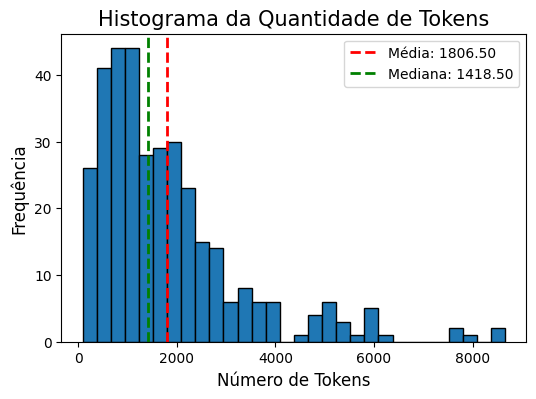

In [ ]:
# Carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/test_data.csv')

# Adicionar coluna com a contagem de tokens
df['token_count'] = df['facts'].apply(count_tokens)

# Exibir o número total de textos no dataset original
total_texts = len(df)
print(f'Total de textos no dataset original: {total_texts}')

# Filtrar textos com menos de 32000 tokens
filtered_df = df[df['token_count'] < 32000].drop(columns=['token_count'])

# Exibir o número de textos filtrados no terminal
total_filtered_texts = len(filtered_df)
print(f'Total de textos filtrados com menos de 32000 tokens: {total_filtered_texts}')

# Plotar histograma da quantidade de tokens
mean_value = df['token_count'].mean()
median_value = df['token_count'].median()

plt.figure(figsize=(6, 4))
plt.hist(df['token_count'], bins=30, edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Média: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {median_value:.2f}')
plt.xlabel('Número de Tokens', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Histograma da Quantidade de Tokens', fontsize=15)
plt.legend()
plt.show()

# Detalhe do Dataset

In [ ]:
import pandas as pd

# Carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/test_data.csv')

# Selecionar um exemplo de cada categoria de 1 a 24
unique_labels = range(1, 25)
examples = []

for label in unique_labels:
    example = df[df['issue_area_label'] == label].head(1)
    examples.append(example)

# Concatenar todos os exemplos em um único DataFrame
examples_df = pd.concat(examples)

# Selecionar as colunas de interesse
selected_columns = examples_df[['issue_area', 'issue_area_label']]

# Exibir o dataset com as colunas selecionadas
from IPython.display import display

display(selected_columns)

print(selected_columns)

,issue_area,issue_area_label
1,AGRAVO,1
104,ALVARA-JUDICIAL-LIBERACAO-DE-CORPO,2
10,APELACAO,3
125,CONSIGNACAO-EM-PAGAMENTO,4
224,CONTRARRAZOES-AO-AGRAVO,5
18,CUMPRIMENTO-DE-SETENCA,6
11,DISSOLUCAO-DE-CONDOMINIO,7
6,EMBARGOS,8
59,EXCECAO-DE-PRE-EXECUTIVIDADE,9
7,EXTINCAO-DE-PUNIBILIDADE,10


                             issue_area  issue_area_label
1                                AGRAVO                 1
104  ALVARA-JUDICIAL-LIBERACAO-DE-CORPO                 2
10                             APELACAO                 3
125            CONSIGNACAO-EM-PAGAMENTO                 4
224             CONTRARRAZOES-AO-AGRAVO                 5
18               CUMPRIMENTO-DE-SETENCA                 6
11             DISSOLUCAO-DE-CONDOMINIO                 7
6                              EMBARGOS                 8
59         EXCECAO-DE-PRE-EXECUTIVIDADE                 9
7              EXTINCAO-DE-PUNIBILIDADE                10
19                        HABEAS-CORPUS                11
5                            IMPUGNACAO                12
4                        INDENIZATORIAS                13
34                    INDULTO-COMUTACAO                14
0                    INTIMACAO-NEGATIVA                15
9                LIVRAMENTO-CONDICIONAL                16
8             

# Classificação Usando as Descrições Geradas

In [ ]:
# Classificação usando descrições com o Sabiá
y_true = []
y_pred = []
results = []
valid_labels = filtered_df['issue_area'].unique().tolist()

print("\nClassificando textos com base nas descrições das categorias...\n")
for index, row in filtered_df.iterrows():
    peticao_text = row['facts']
    messages = create_messages_for_classification(peticao_text)
    result = get_sabia_response(messages)["answer"].strip()

    normalized_label = clean_category(remove_accents(row['issue_area'].strip().upper()))
    normalized_result = get_best_match(result, valid_labels)

    y_true.append(normalized_label)
    y_pred.append(clean_category(remove_accents(normalized_result.strip().upper())))

    # Cálculo das métricas em tempo real
    correct_count = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total_count = len(y_true)
    accuracy = correct_count / total_count * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100

    # Exibição dos resultados em tempo real
    print(f'Real: {row["issue_area"]}, Previsto: {normalized_result}, Correto: {normalized_label == clean_category(remove_accents(normalized_result.strip().upper()))}')
    print(f'Progresso: {index + 1}/{len(filtered_df)}')
    print(f'Acurácia até agora: {accuracy:.2f}%')
    print(f'Precisão até agora: {precision:.2f}%')
    print(f'Recall até agora: {recall:.2f}%')
    print(f'F1-score até agora: {f1:.2f}%\n')


Classificando textos com base nas descrições das categorias...

Real: INTIMACAO-NEGATIVA, Previsto: PROGRESSAO-DE-REGIME, Correto: False
Progresso: 1/346
Acurácia até agora: 0.00%
Precisão até agora: 0.00%
Recall até agora: 0.00%
F1-score até agora: 0.00%

Real: AGRAVO, Previsto: AGRAVO, Correto: True
Progresso: 2/346
Acurácia até agora: 50.00%
Precisão até agora: 50.00%
Recall até agora: 50.00%
F1-score até agora: 50.00%

Real: REGISTRO-CIVIL, Previsto: REGISTRO-CIVIL, Correto: True
Progresso: 3/346
Acurácia até agora: 66.67%
Precisão até agora: 66.67%
Recall até agora: 66.67%
F1-score até agora: 66.67%

Real: AGRAVO, Previsto: AGRAVO, Correto: True
Progresso: 4/346
Acurácia até agora: 75.00%
Precisão até agora: 75.00%
Recall até agora: 75.00%
F1-score até agora: 75.00%

Real: INDENIZATORIAS, Previsto: CUMPRIMENTO-DE-SETENCA, Correto: False
Progresso: 5/346
Acurácia até agora: 60.00%
Precisão até agora: 60.00%
Recall até agora: 60.00%
F1-score até agora: 60.00%

Real: IMPUGNACAO, Pre

# Salvar Resultados

In [ ]:
# Gerar relatório de classificação em formato de dicionário
report_dict = classification_report(y_true, y_pred, labels=valid_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Caminhos para salvar os arquivos
report_csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classification_report_resumos.csv'
report_excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classification_report_resumos.xlsx'

# Salvar o relatório de classificação em CSV e Excel
report_df.to_csv(report_csv_path, index=True)
report_df.to_excel(report_excel_path, index=True)

print(f'Relatório de classificação salvo em {report_csv_path} e {report_excel_path}')

# Criar um DataFrame a partir dos resultados detalhados
results_df = pd.DataFrame(results)

# Definir os caminhos para salvar os arquivos
csv_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classificacoes_resumos.csv'
excel_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classificacoes_resumos.xlsx'

# Salvar os resultados detalhados em CSV e Excel
results_df.to_csv(csv_path, index=False)
results_df.to_excel(excel_path, index=False)

print(f'Resultados salvos em {csv_path} e {excel_path}')

Relatório de classificação salvo em /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classification_report_resumos.csv e /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classification_report_resumos.xlsx
Resultados salvos em /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classificacoes_resumos.csv e /content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Classificações/classificacoes_resumos.xlsx


# Cálculo das Métricas e Exibição dos Resultados


In [ ]:
labels = list(set(y_true))

# Calcular métricas e exibir resultados
print("\nCálculo de métricas finais...\n")
print(f'Acurácia: {accuracy_score(y_true, y_pred) * 100:.2f}%')
print(f'Precisão: {precision_score(y_true, y_pred, average="weighted") * 100:.2f}%')
print(f'Recall: {recall_score(y_true, y_pred, average="weighted") * 100:.2f}%')
print(f'F1-score: {f1_score(y_true, y_pred, average="weighted") * 100:.2f}%')

# Gerar relatório detalhado de classificação
print("\nRelatório detalhado de classificação:\n")
print(classification_report(y_true, y_pred, labels=labels))


Cálculo de métricas finais...

Acurácia: 88.15%
Precisão: 92.57%
Recall: 88.15%
F1-score: 89.42%

Relatório detalhado de classificação:

                                    precision    recall  f1-score   support

            CUMPRIMENTO-DE-SETENCA       0.74      0.93      0.82        15
          DISSOLUCAO-DE-CONDOMINIO       1.00      1.00      1.00         3
                        IMPUGNACAO       0.97      0.83      0.90        42
                INTIMACAO-NEGATIVA       0.50      0.33      0.40         3
                  SAIDA-TEMPORARIA       1.00      1.00      1.00         1
                    INDENIZATORIAS       0.93      0.93      0.93        15
               UNIFICACAO-DE-PENAS       0.00      0.00      0.00         3
          EXTINCAO-DE-PUNIBILIDADE       0.98      0.96      0.97        50
      EXCECAO-DE-PRE-EXECUTIVIDADE       0.90      1.00      0.95         9
         TRANSFERENCIA-DE-EXECUCAO       0.73      1.00      0.84         8
ALVARA-JUDICIAL-LIBERACAO

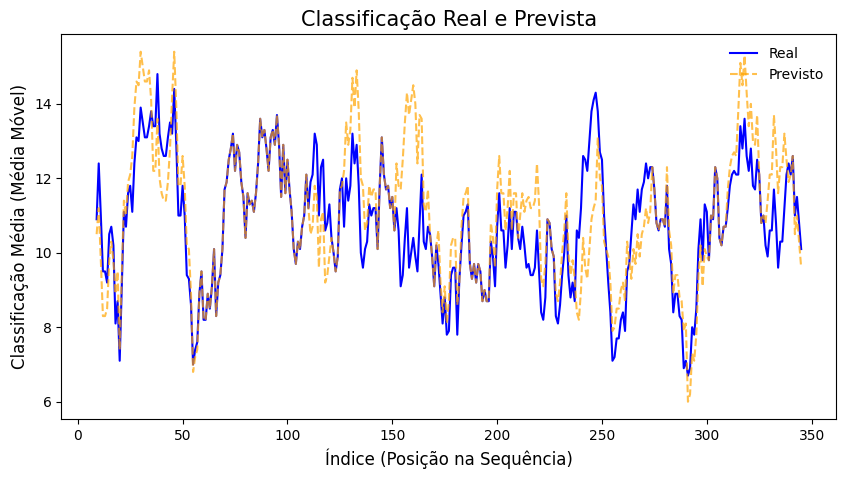

Acurácia Total: 88.15%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter categorias para números
label_mapping = {label: idx for idx, label in enumerate(set(y_true + y_pred))}
numeric_labels_true = [label_mapping[label] for label in y_true]
numeric_labels_pred = [label_mapping[label] for label in y_pred]

# Criar DataFrame para comparação
df_comparison = pd.DataFrame({'Real': numeric_labels_true, 'Previsto': numeric_labels_pred})

# Calcular a acurácia
accuracy = (df_comparison['Real'] == df_comparison['Previsto']).mean()

# Calcular a média móvel para suavizar as curvas (usando uma janela de 10)
df_comparison['Real_Smooth'] = df_comparison['Real'].rolling(window=10).mean()
df_comparison['Previsto_Smooth'] = df_comparison['Previsto'].rolling(window=10).mean()

# Criar o gráfico de linhas
plt.figure(figsize=(10, 5))  # Ajustar o tamanho do gráfico
plt.plot(df_comparison.index, df_comparison['Real_Smooth'], label='Real', linestyle='-', color='blue')
plt.plot(df_comparison.index, df_comparison['Previsto_Smooth'], label='Previsto', linestyle='--', color='orange', alpha=0.7)
plt.xlabel('Índice (Posição na Sequência)', fontsize=12)  # Eixo X representando a posição na sequência
plt.ylabel('Classificação Média (Média Móvel)', fontsize=12)  # Eixo Y representando a média móvel das classificações
plt.title('Classificação Real e Prevista', fontsize=15)
plt.legend(loc='upper right', fontsize=10, frameon=False)  # Reduzir o tamanho da fonte da legenda e remover o quadro
plt.show()

# Exibir a acurácia
print(f'Acurácia Total: {accuracy:.2%}')

# Mapear categorias e Demais métricas de Avaliação

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar os rótulos de string para valores numéricos
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

# Verificar o mapeamento
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'AGRAVO': 0, 'ALVARA-JUDICIAL-LIBERACAO-DE-CORPO': 1, 'APELACAO': 2, 'CONSIGNACAO-EM-PAGAMENTO': 3, 'CONTRARRAZOES-AO-AGRAVO': 4, 'CUMPRIMENTO-DE-SETENCA': 5, 'DISSOLUCAO-DE-CONDOMINIO': 6, 'EMBARGOS': 7, 'EXCECAO-DE-PRE-EXECUTIVIDADE': 8, 'EXTINCAO-DE-PUNIBILIDADE': 9, 'HABEAS-CORPUS': 10, 'IMPUGNACAO': 11, 'INDENIZATORIAS': 12, 'INDULTO-COMUTACAO': 13, 'INTIMACAO-NEGATIVA': 14, 'LIVRAMENTO-CONDICIONAL': 15, 'OFICIOS': 16, 'PROGRESSAO-DE-REGIME': 17, 'REGISTRO-CIVIL': 18, 'REMICAO-DE-PENA': 19, 'SAIDA-TEMPORARIA': 20, 'TRANSFERENCIA-DE-EXECUCAO': 21, 'UNIFICACAO-DE-PENAS': 22, 'USUCAPIAO': 23}


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# Binarizar as classes para cálculos de AUC-ROC e AUC-PR
y_true_binarized = label_binarize(y_true_encoded, classes=np.arange(len(label_encoder.classes_)))
y_pred_binarized = label_binarize(y_pred_encoded, classes=np.arange(len(label_encoder.classes_)))

# Usar um classificador básico para One-vs-Rest
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf.fit(y_true_binarized, y_true_encoded)
y_score = clf.decision_function(y_pred_binarized)

# Inicializar dicionários para armazenar os resultados por categoria
category_metrics = {}

# Listas para armazenar os resultados para cada categoria
labels = []
auc_roc_list = []
auc_pr_list = []
mcc_list = []

# Calcular métricas por categoria
for i, label in enumerate(label_encoder.classes_):
    # AUC-ROC para a categoria específica
    roc_auc = roc_auc_score(y_true_binarized[:, i], y_score[:, i])
    # AUC-PR para a categoria específica
    average_precision = average_precision_score(y_true_binarized[:, i], y_score[:, i])
    # MCC para a categoria específica (usando rótulos binários)
    y_true_binary = y_true_binarized[:, i]
    y_pred_binary = (y_score[:, i] >= 0.5).astype(int)
    mcc = matthews_corrcoef(y_true_binary, y_pred_binary)

    # Armazenar os resultados para cada categoria
    labels.append(label)
    auc_roc_list.append(roc_auc)
    auc_pr_list.append(average_precision)
    mcc_list.append(mcc)

    # Exibir os resultados para cada categoria
    print(f"Categoria: {label}")
    print(f"AUC-ROC: {roc_auc:.2f}")
    print(f"AUC-PR: {average_precision:.2f}")
    print(f"MCC: {mcc:.2f}\n")

# Criar um DataFrame com os resultados por categoria
df_metrics = pd.DataFrame({
    "Categoria": labels,
    "AUC-ROC": auc_roc_list,
    "AUC-PR": auc_pr_list,
    "MCC": mcc_list
})

# Salvar o DataFrame no formato Excel e CSV
output_directory = "/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Demais-métricas"
excel_path = f"{output_directory}/metricas_por_categoria.xlsx"
csv_path = f"{output_directory}/metricas_por_categoria.csv"

df_metrics.to_excel(excel_path, index=False, engine='openpyxl')
df_metrics.to_csv(csv_path, index=False)

print(f"Resultados salvos com sucesso em:\n{excel_path}\n{csv_path}")

# Calcular e exibir as métricas gerais (médias ponderadas)
roc_auc_weighted = roc_auc_score(y_true_binarized, y_score, average='weighted', multi_class='ovr')
average_precision_weighted = average_precision_score(y_true_binarized, y_score, average='weighted')
mcc_weighted = matthews_corrcoef(y_true_encoded, y_pred_encoded)

print("Métricas Gerais (Médias Ponderadas):")
print(f"AUC-ROC (weighted): {roc_auc_weighted:.2f}")
print(f"AUC-PR (weighted): {average_precision_weighted:.2f}")
print(f"MCC (weighted): {mcc_weighted:.2f}")

Categoria: AGRAVO
AUC-ROC: 1.00
AUC-PR: 0.99
MCC: 0.99

Categoria: ALVARA-JUDICIAL-LIBERACAO-DE-CORPO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: APELACAO
AUC-ROC: 1.00
AUC-PR: 0.92
MCC: 0.76

Categoria: CONSIGNACAO-EM-PAGAMENTO
AUC-ROC: 1.00
AUC-PR: 0.50
MCC: 0.00

Categoria: CONTRARRAZOES-AO-AGRAVO
AUC-ROC: 0.98
AUC-PR: 0.07
MCC: 0.00

Categoria: CUMPRIMENTO-DE-SETENCA
AUC-ROC: 0.98
AUC-PR: 0.70
MCC: 0.82

Categoria: DISSOLUCAO-DE-CONDOMINIO
AUC-ROC: 1.00
AUC-PR: 1.00
MCC: 0.00

Categoria: EMBARGOS
AUC-ROC: 0.99
AUC-PR: 0.88
MCC: 0.89

Categoria: EXCECAO-DE-PRE-EXECUTIVIDADE
AUC-ROC: 1.00
AUC-PR: 0.90
MCC: 0.00

Categoria: EXTINCAO-DE-PUNIBILIDADE
AUC-ROC: 0.99
AUC-PR: 0.95
MCC: 0.96

Categoria: HABEAS-CORPUS
AUC-ROC: 1.00
AUC-PR: 0.60
MCC: 0.00

Categoria: IMPUGNACAO
AUC-ROC: 0.94
AUC-PR: 0.87
MCC: 0.89

Categoria: INDENIZATORIAS
AUC-ROC: 0.98
AUC-PR: 0.88
MCC: 0.93

Categoria: INDULTO-COMUTACAO
AUC-ROC: 0.89
AUC-PR: 0.84
MCC: 0.90

Categoria: INTIMACAO-NEGATIVA
AUC-ROC: 0.94
A

# Métricas de Avaliação - Gráfico

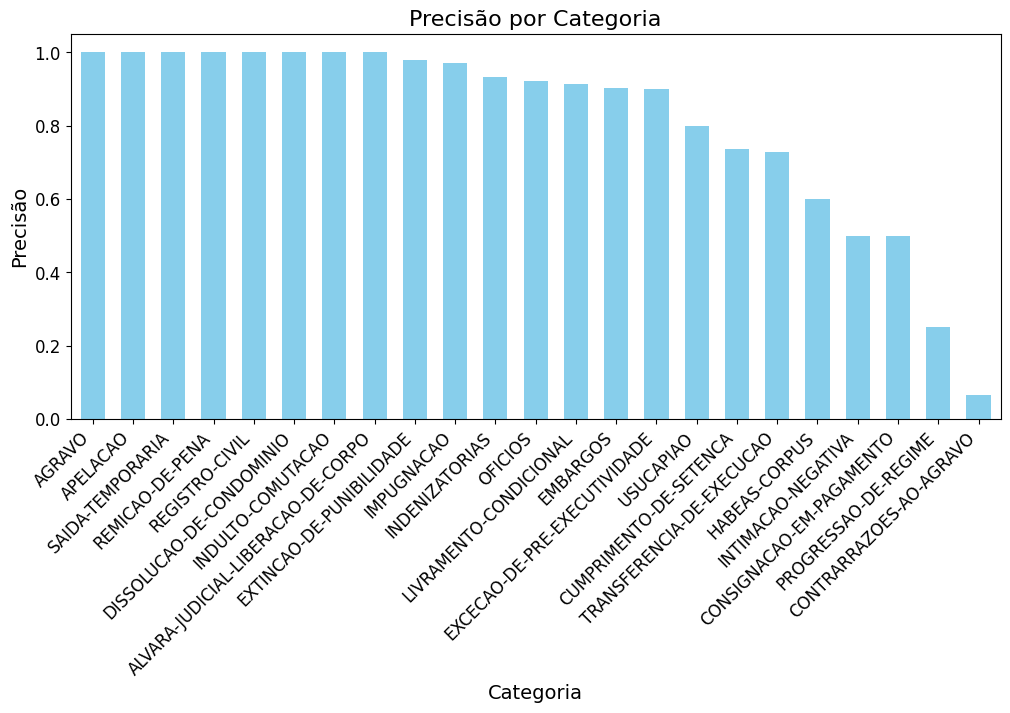

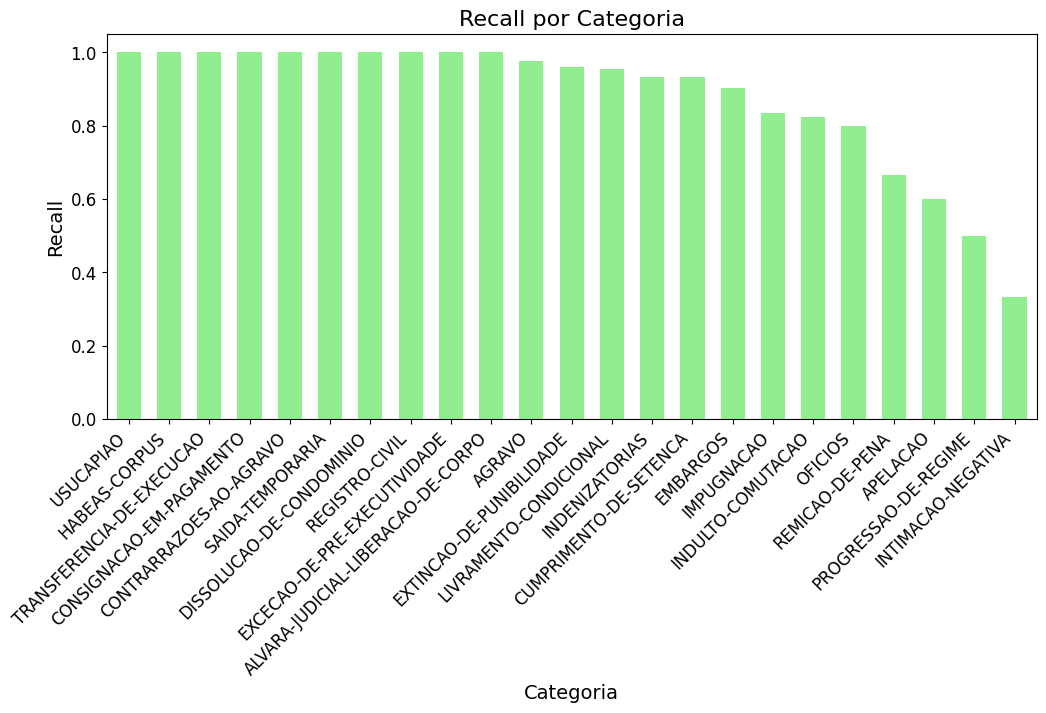

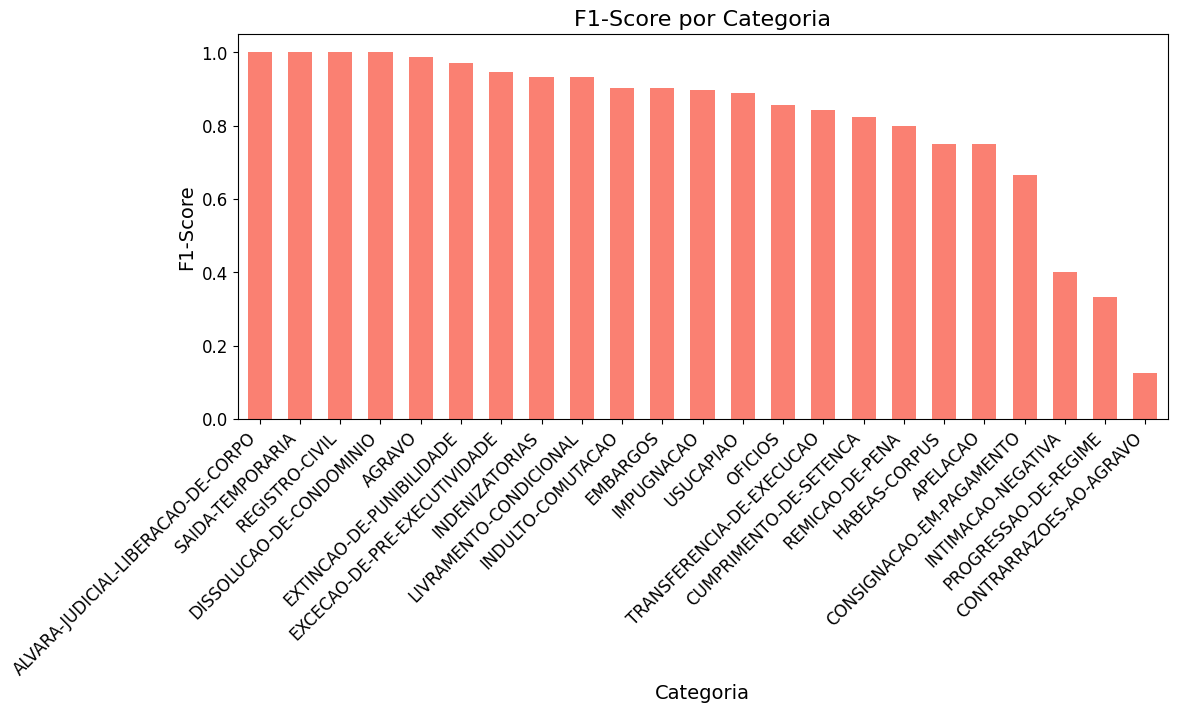

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Calcular o relatório de classificação
report_dict = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Remover categorias com resultados zero e médias indesejadas
df_report = df_report[(df_report['precision'] > 0) | (df_report['recall'] > 0) | (df_report['f1-score'] > 0)]
df_report = df_report.drop(['accuracy', 'macro avg', 'weighted avg', 'micro avg'], errors='ignore')

# Ajustar a largura das barras
bar_width = 0.6

# Ordenar os valores para visualização pela precisão
df_report_precision = df_report.sort_values(by='precision', ascending=False)

# Precisão
plt.figure(figsize=(12, 5))
df_report_precision['precision'].plot(kind='bar', color='skyblue', width=bar_width)
plt.title('Precisão por Categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=14)
plt.ylabel('Precisão', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo recall
df_report_recall = df_report.sort_values(by='recall', ascending=False)

# Recall
plt.figure(figsize=(12, 5))
df_report_recall['recall'].plot(kind='bar', color='lightgreen', width=bar_width)
plt.title('Recall por Categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Ordenar os valores para visualização pelo f1-score
df_report_f1 = df_report.sort_values(by='f1-score', ascending=False)

# F1-Score
plt.figure(figsize=(12, 5))
df_report_f1['f1-score'].plot(kind='bar', color='salmon', width=bar_width)
plt.title('F1-Score por Categoria', fontsize=16)
plt.xlabel('Categoria', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.show()

# Matriz de Confusão

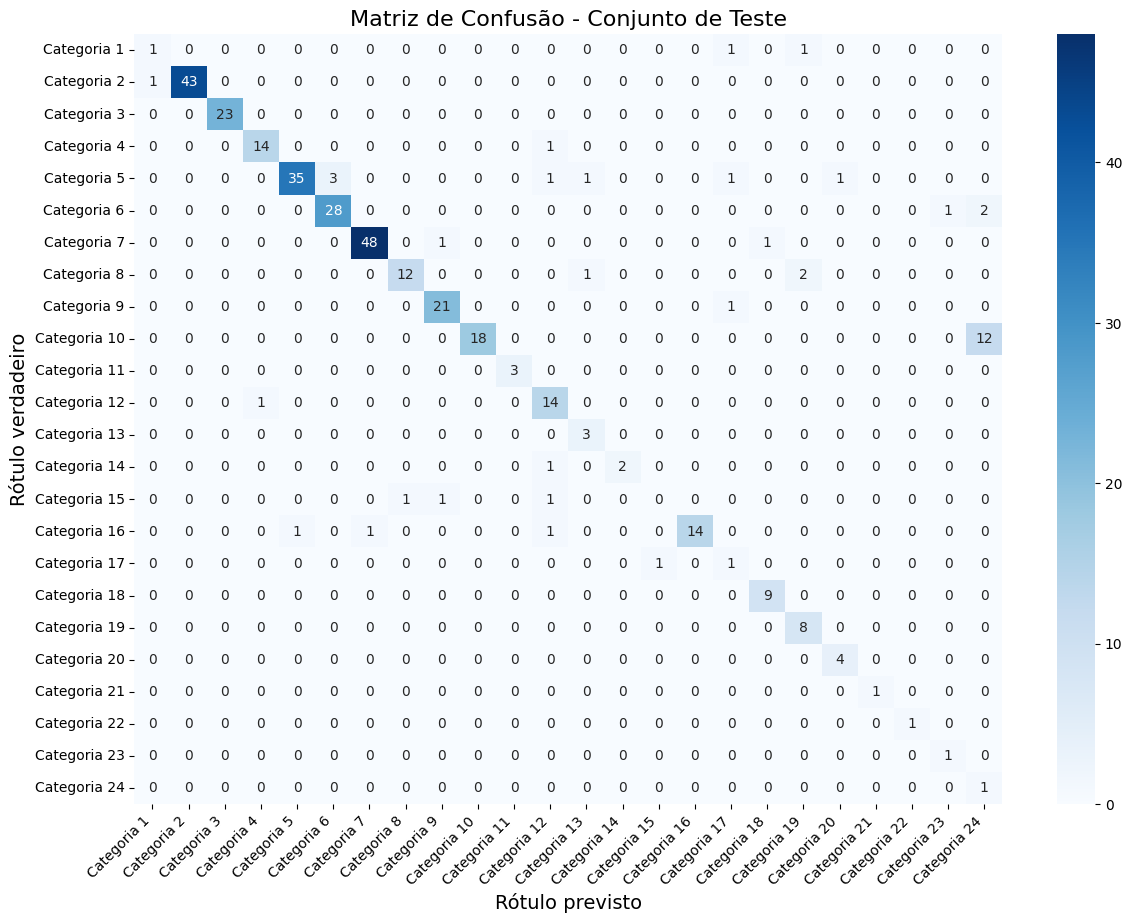

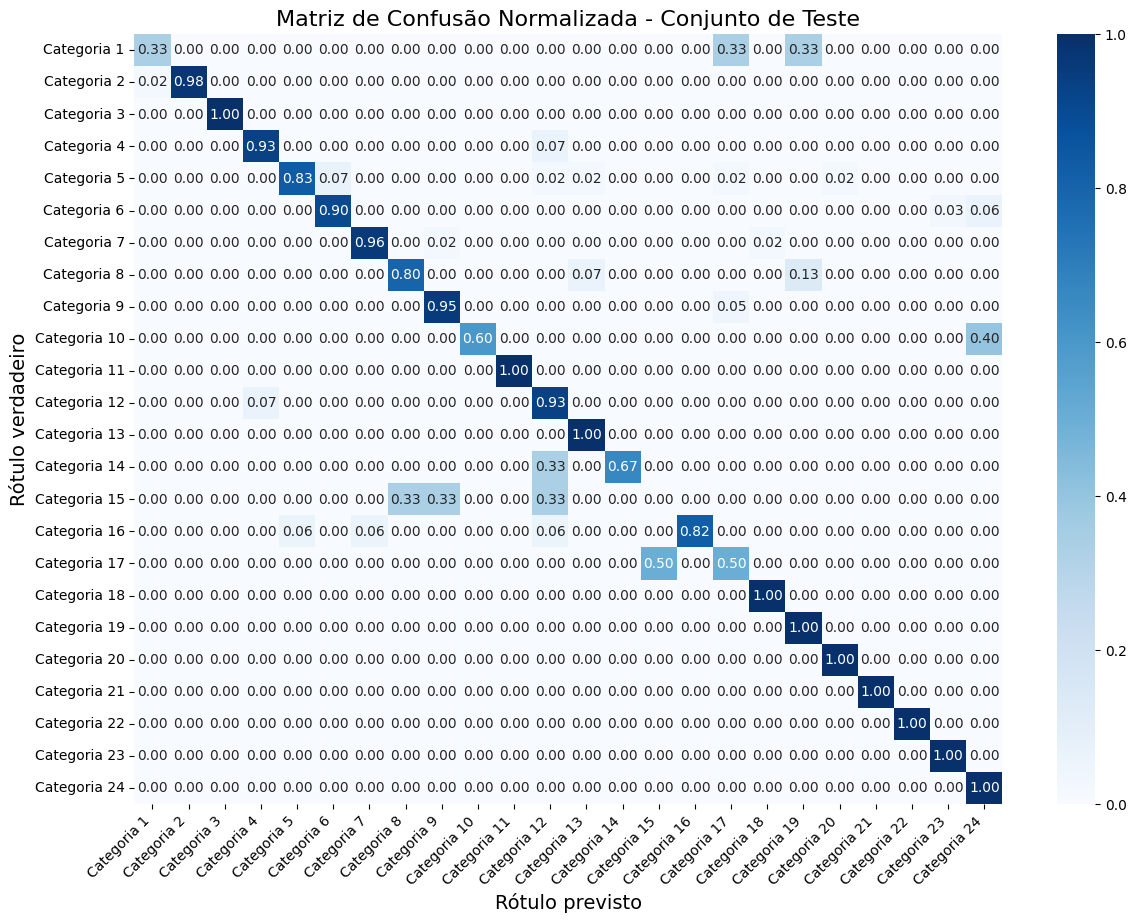

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# df_sample é o DataFrame contendo os rótulos verdadeiros e previstos
df_sample = pd.DataFrame({
    'issue_area': y_true,
    'resultados': y_pred
})

# Calcular a matriz de confusão
cm = confusion_matrix(df_sample['issue_area'], df_sample['resultados'], labels=df_sample['issue_area'].unique())

# Normalizar a matriz de confusão
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Criar rótulos numéricos para as categorias
categories = [f'Categoria {i+1}' for i in range(len(df_sample['issue_area'].unique()))]

# Criar DataFrames para as matrizes de confusão
df_cm = pd.DataFrame(cm, index=categories, columns=categories)
df_cm_normalized = pd.DataFrame(cm_normalized, index=categories, columns=categories)

# Definir o diretório de saída
output_dir = '/content/drive/MyDrive/Colab Notebooks/Defesa final/LLMs/Sabiá-3/Classificação usando Descrições/Matriz-confusão'

# Salvar as matrizes de confusão em CSV e Excel
df_cm.to_csv(f'{output_dir}/matriz_de_confusao.csv', index=True)
df_cm_normalized.to_csv(f'{output_dir}/matriz_de_confusao_normalizada.csv', index=True)

df_cm.to_excel(f'{output_dir}/matriz_de_confusao.xlsx', index=True)
df_cm_normalized.to_excel(f'{output_dir}/matriz_de_confusao_normalizada.xlsx', index=True)

# Plotar a matriz de confusão normal
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Rótulo previsto', fontsize=14)
plt.ylabel('Rótulo verdadeiro', fontsize=14)
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Plotar a matriz de confusão normalizada
plt.figure(figsize=(14, 10))
sns.heatmap(df_cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Rótulo previsto', fontsize=14)
plt.ylabel('Rótulo verdadeiro', fontsize=14)
plt.title('Matriz de Confusão Normalizada - Conjunto de Teste', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Gerar uma Petição Fictícia

In [ ]:
# Função para gerar uma petição fictícia com base em uma classe específica
def generate_fictitious_petition(category):
    messages = [
        {"role": "user", "content": (
            f"Crie uma petição fictícia no contexto de {category}. A petição deve ser fictícia e não conter informações reais. "
            "Descreva de forma geral o caso, incluindo uma narrativa comum, mas sem detalhes precisos como nomes reais, endereços ou números de processos."
        )}
    ]
    response = get_sabia_response(messages, max_tokens=300)
    print(f"Petição fictícia gerada para a classe {category}:\n")
    print(response['answer'])

# Categoria para gerar a petição fictícia
category = "HABEAS-CORPUS"
generate_fictitious_petition(category)

Petição fictícia gerada para a classe HABEAS-CORPUS:

EXCELENTÍSSIMO SENHOR DOUTOR DESEMBARGADOR PRESIDENTE DO EGRÉGIO TRIBUNAL DE JUSTIÇA DO ESTADO [SIGLA DO ESTADO]

IMPETRANTE: [Nome Fictício do Advogado], Advogado(a)
IMPETRADO: Juízo da [Número]a Vara Criminal da Comarca de [Cidade Fictícia]
PACIENTE: [Nome Fictício do Paciente]
AUTORIDADE COATORA: Juiz(a) de Direito da [Número]a Vara Criminal da Comarca de [Cidade Fictícia]

PETIÇÃO DE HABEAS CORPUS COM PEDIDO DE LIMINAR

[Nome Fictício do Advogado], advogado(a), inscrito(a) na OAB/[Sigla do Estado] sob o no [Número Fictício], com escritório profissional na [Endereço Fictício], onde recebe intimações, vem, respeitosamente, à presença de Vossa Excelência, com fundamento no artigo 5o, inciso LXVIII, da Constituição Federal e nos artigos 647 e seguintes do Código de Processo Penal, impetrar ordem de

HABEAS CORPUS COM PEDIDO DE LIMINAR

em favor de [Nome F


# Classificar uma Petição Fictícia

In [ ]:
# Função para classificar uma petição fictícia
def classify_fictitious_petition(text):
    messages = create_messages_for_classification(text)
    result = get_sabia_response(messages)["answer"].strip()
    normalized_result = get_best_match(result, valid_labels)
    print(f"Texto Classificado:\n{text}\n")
    print(f"Categoria Prevista: {normalized_result}")

# Gerar uma petição fictícia e classificá-la
fictitious_petition = """
Considerando a narrativa apresentada, requer-se a concessão do habeas corpus para o restabelecimento da liberdade do paciente,
uma vez que a prisão preventiva não se justifica frente à ausência de indícios concretos que apontem para a participação direta do paciente nos fatos investigados.
"""
classify_fictitious_petition(fictitious_petition)

Texto Classificado:

Considerando a narrativa apresentada, requer-se a concessão do habeas corpus para o restabelecimento da liberdade do paciente,
uma vez que a prisão preventiva não se justifica frente à ausência de indícios concretos que apontem para a participação direta do paciente nos fatos investigados.


Categoria Prevista: HABEAS-CORPUS
